### Jang suk Roh 
### 06606
### Stability and Computing Cost Comparison Between BDF and RK45 For Polymerization Reactor Case Study

# Warning
Running all the code requires significant time. Allow 3 hours to compute.

## Modules

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
%matplotlib inline

## Parameters

In [2]:
#total solve time calculation
tictic = time.perf_counter()

#Ideal gas constant
Rg = 1.987 #cal/mol/K

#Chemical initiation kinetic constant
def k_d(T): 
    return 9.1e13 * np.exp(-29508/Rg/T) #1/s

#Thermal initiation kinetic constant
def k_i0(T):
    return 1.1e5 * np.exp(-27340/Rg/T) #L^2/(mol^2*s)

#Chemical initiation kinetic constant (size 1)
def k_i1(T):
    return 1.0e7 * np.exp(-7067/Rg/T) #L/(mol*s)

#Polybutadiene activation chemical initiation kinetic constant
def k_i2(T):
    return 2.0e6 * np.exp(-7067/Rg/T) #L/(mol*s)

#Grafted chemical initiation kinetic constant (size 1)
def k_i3(T):
    return 1.0e7 * np.exp(-7067/Rg/T) #L/(mol*s)

#Propagation kinetic constant 
def k_p(T):
    return 1.0e7 * np.exp(-7067/Rg/T) #L/(mol*s)

#Styrene monomer transfer kinetic constant 
def k_fs(T):
    return 6.6e7 * np.exp(-14400/Rg/T) #L/(mol*s)

#Polybutadiene transfer kinetic constant 
def k_fb(T):
    return 2.3e9 * np.exp(-18000/Rg/T) #L/(mol*s)

#Monomer conversion fraction
def xs(c_m):
    return (c_m0 - c_m)/c_m0

#Coupling termination kinetic constant 
def k_t(T,c_m):
    C_1 = 2.57 - 0.00505*T
    C_2 = 9.56 - 0.0176*T
    C_3 = -3.03 + 0.00785*T
    XS = xs(c_m)
    
    return 1.7e9 * np.exp((-843/T) - 2*(C_1*XS + C_2*XS**2 + C_3*XS**3))

V = 9450 #Volume (L)
V_j = 2000 #Jacket Volume (L)
F = 1.14 #Feedstream volumetric flow rate (L/s)
F_i = 0 #Initiator volumetric flow rate. 0 for A1 and A4 transition(L/s)
F_j = 1 #Cooling water volumetric flow rate (L/s)
f = 0.57 #Initiator efficiency 
dH = -69919.56 #Heat of reaction (j/mol)
rho_s = 0.915 #Monomer density (kg/L)
rho_j = 1 #Cooling water density (kg/L)
c_ps = 1647.27 #Monomer heat capacity (j/kg/K)
c_pj = 4045.7 #Cooling water heat capacity (j/kg/K)
U = 80 #Heat transfer coefficient (j/s/K/m^2)
A = 19.5 #Heat transfer area(m^2)

## Differential Algebraic Equation

In [3]:
def DAE(t,X):
    c_i, c_m, c_b, c_r, c_br, mu_r0, mu_b0, T, T_j = X
    #initiator conc, monomer conc, butadiene conc, radical conc, branched radical conc, 0th moment dead radical, 0th moment dead butadiene, reactor temperature, jacket temperature
        
    dc_idt = (F_i * c_i0 - F * c_i)/V - k_d(T)*c_i
    
    dc_mdt = F * (c_m0 - c_m)/V - k_p(T)*c_m*(mu_r0 + mu_b0)
    
    dc_bdt = F * (c_b0 - c_b)/V - c_b*(k_i2(T)*c_r + k_fs(T)*mu_r0 + k_fb(T)*mu_b0)
    
    dc_rdt = 2*f*k_d(T)*c_i - c_r*(k_i1(T)*c_m + k_i2(T)*c_b)
    
    dc_brdt = c_b*(k_i2(T)*c_r + k_fb(T)*(mu_r0 + mu_b0)) - c_br*(k_i3(T)*c_m + k_t(T,c_m)*(mu_r0 + mu_b0 + c_br))
    
    dmu_r0dt = 2*k_i0(T)*c_m**3 + k_i1(T)*c_r*c_m + c_m*k_fs(T)*(mu_r0 + mu_b0) -(k_p(T)*c_m + k_t(T,c_m)*(mu_r0 + mu_b0 + c_br) + k_fs(T)*c_m + k_fb(T)*c_b)*mu_r0 + k_p(T)*c_m*mu_r0
    
    dmu_b0dt = k_i3(T)*c_br*c_m - (k_p(T)*c_m + k_t(T,c_m)*(mu_r0 + mu_b0 + c_br) + k_fs(T)*c_m + k_fb(T)*c_b)*mu_b0 + k_p(T)*c_m*mu_b0
    
    dTdt = F*(T_0 - T)/V - dH*k_p(T)*c_m*(mu_r0 + mu_b0)/rho_s/c_ps - U*A*(T - T_j)/rho_s/c_ps/V
    
    dT_jdt = F_j*(T_j0 - T_j)/V_j + U*A*(T - T_j)/rho_j/c_pj/V_j
    
    return np.array([dc_idt, dc_mdt, dc_bdt, dc_rdt, dc_brdt, dmu_r0dt, dmu_b0dt, dTdt, dT_jdt])   
    

## Reference Case

In [4]:
#initial conditions
F_i = 0.0015 

c_i0 = 0.981 #mol/L
c_m0 = 8.63 #mol/L
c_b0 = 1.05 #mol/L
c_r0 = 0 #mol/L
c_br0 = 0 #mol/L
mu_r00 = 0
mu_b00 = 0
T_0 = 333 #K
T_j0 = 294 #K

y0 = np.array([c_i0,c_m0,c_b0,c_r0,c_br0,mu_r00,mu_b00,T_0,T_j0])

### Accuracy Comparison Between BDF and RK45

#### RK45 

In [5]:
#RK45 first 10 min and plots
tic = time.perf_counter()
tspan = (0,600) # 10 min
teval, h = np.linspace(*tspan,500, retstep = True)
ref_sol1 = solve_ivp(DAE,tspan,y0,method = 'RK45',t_eval = teval)
toc = time.perf_counter()
computation_time = toc - tic

print(computation_time,'seconds')

206.3183523 seconds


#### BDF

In [6]:
#BDF first 10 min and plots
tic = time.perf_counter()
tspan = (0,600) # 10 min
teval, h = np.linspace(*tspan,500, retstep = True)
ref_sol2 = solve_ivp(DAE,tspan,y0,method = "BDF",t_eval = teval)
toc = time.perf_counter()
computation_time = toc - tic

print(computation_time,'seconds')

0.024642899999975043 seconds


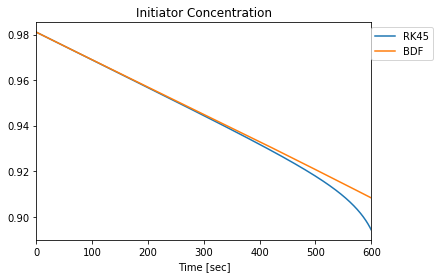

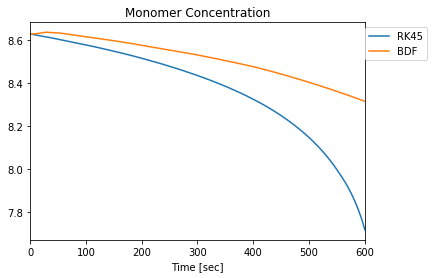

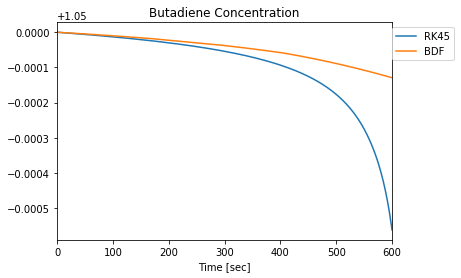

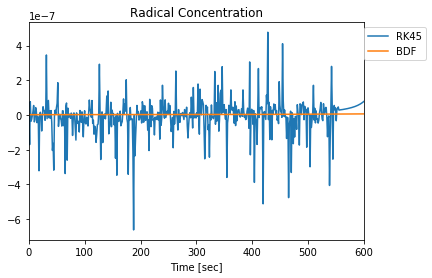

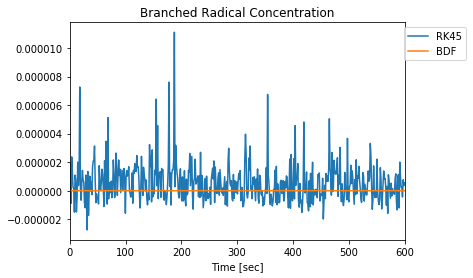

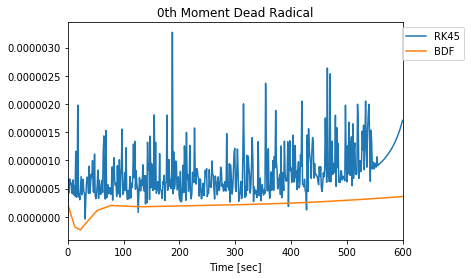

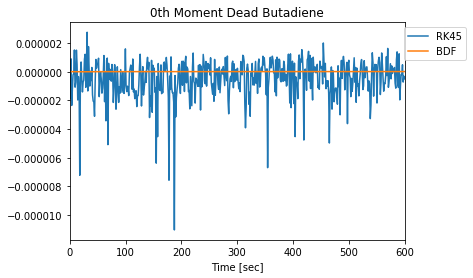

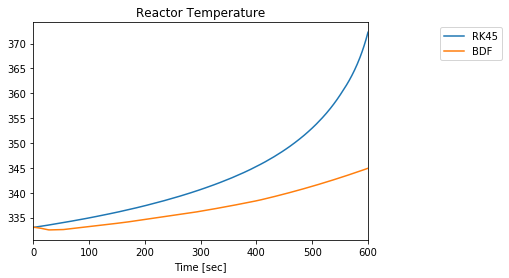

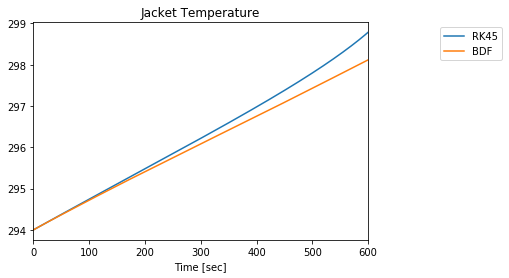

In [7]:
AA = len(y0)
title = ['Initiator Concentration','Monomer Concentration','Butadiene Concentration', 'Radical Concentration','Branched Radical Concentration',
        '0th Moment Dead Radical', '0th Moment Dead Butadiene', 'Reactor Temperature', 'Jacket Temperature']

for i in range(AA):
    plt.plot(ref_sol1.t,ref_sol1.y[i],ref_sol2.t,ref_sol2.y[i])
    plt.title(title[i])
    plt.xlabel('Time [sec]')
    plt.xlim(ref_sol1.t.min(),ref_sol1.t.max())
    plt.legend(['RK45','BDF'],bbox_to_anchor = [1.2,1])
    plt.show()

### Computing Time Comparison Between BDF and RK45

#### RK45

In [8]:
#Solver = RK45
points = np.array([25,50,75,100,125,150,175,200,250])
step_size1 = np.zeros(len(points))
solve_time1 = np.zeros(len(points))

for i,p in enumerate(points):
    tic = time.perf_counter()
    tspan = (0,600)
    teval, h = np.linspace(*tspan,p, retstep = True)
    ref_sol3 = solve_ivp(DAE,tspan,y0,method='RK45',t_eval = teval)
    toc = time.perf_counter()
    comp_time = toc - tic
    
    step_size1[i] = h
    solve_time1[i] = comp_time

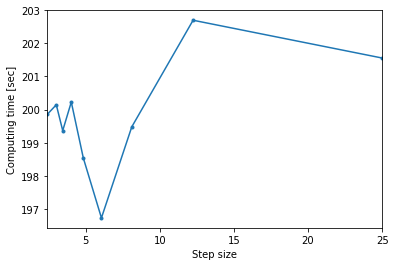

In [9]:
plt.plot(step_size1, solve_time1,'.-')
plt.xlabel("Step size")
plt.ylabel("Computing time [sec]")
plt.xlim(step_size1.min(), step_size1.max())
plt.show()

#### BDF

In [10]:
#Solver = BDF
step_size2 = np.zeros(len(points))
solve_time2 = np.zeros(len(points))

for i,p in enumerate(points):
    tic = time.perf_counter()
    tspan = (0,500)
    teval, h = np.linspace(*tspan,p, retstep = True)
    ref_sol4 = solve_ivp(DAE,tspan,y0,method='BDF',t_eval = teval,max_step = h)
    toc = time.perf_counter()
    comp_time = toc - tic
    
    step_size2[i] = h
    solve_time2[i] = comp_time

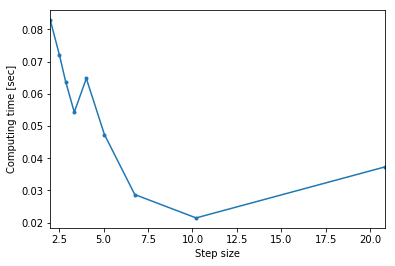

In [11]:
plt.plot(step_size2, solve_time2,'.-')
plt.xlabel("Step size")
plt.ylabel("Computing time [sec]")
plt.xlim(step_size2.min(), step_size2.max())
plt.show()

## A4 Case (Stable)

In [12]:
#initial conditions
F_i = 0.00 
F_j = 10

c_i0 = 1e-4 #mol/L
c_m0 = 6.3 #mol/L
c_b0 = 1.05 #mol/L
c_r0 = 0 #mol/L
c_br0 = 0 #mol/L
mu_r00 = 0
mu_b00 = 0
T_0 = 390 #K
T_j0 = 320 #K

y0 = np.array([c_i0,c_m0,c_b0,c_r0,c_br0,mu_r00,mu_b00,T_0,T_j0])

### Computing Time Comparison Between BDF and RK45

#### RK45

In [13]:
#Solver = RK45
points = np.array([10,25,50,75,100])
step_size3 = np.zeros(len(points))
solve_time3 = np.zeros(len(points))

for i,p in enumerate(points):
    tic = time.perf_counter()
    tspan = (0,600)
    teval, h = np.linspace(*tspan,p, retstep = True)
    A4_sol1 = solve_ivp(DAE,tspan,y0,method='RK45',t_eval = teval)
    toc = time.perf_counter()
    comp_time = toc - tic
    
    step_size3[i] = h
    solve_time3[i] = comp_time

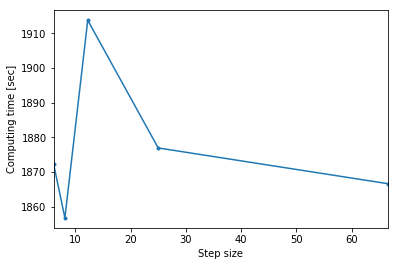

In [14]:
plt.plot(step_size3, solve_time3,'.-')
plt.xlabel("Step size")
plt.ylabel("Computing time [sec]")
plt.xlim(step_size3.min(), step_size3.max())
plt.show()

#### BDF

In [15]:
#Solver = BDF
step_size4 = np.zeros(len(points))
solve_time4 = np.zeros(len(points))

for i,p in enumerate(points):
    tic = time.perf_counter()
    tspan = (0,500)
    teval, h = np.linspace(*tspan,p, retstep = True)
    A4_sol2 = solve_ivp(DAE,tspan,y0,method='BDF',t_eval = teval,max_step = h)
    toc = time.perf_counter()
    comp_time = toc - tic
    
    step_size4[i] = h
    solve_time4[i] = comp_time

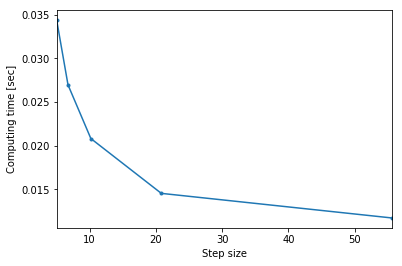

In [16]:
plt.plot(step_size4, solve_time4,'.-')
plt.xlabel("Step size")
plt.ylabel("Computing time [sec]")
plt.xlim(step_size4.min(), step_size4.max())
plt.show()

## A1 Case (Unstable)

In [17]:
#initial conditions
F_i = 0.0015
F_j = 0.5

c_i0 = 8e-5 #mol/L
c_m0 = 6.3 #mol/L
c_b0 = 1.05 #mol/L
c_r0 = 0 #mol/L
c_br0 = 0 #mol/L
mu_r00 = 0
mu_b00 = 0
T_0 = 390 #K
T_j0 = 320 #K

y0 = np.array([c_i0,c_m0,c_b0,c_r0,c_br0,mu_r00,mu_b00,T_0,T_j0])

### Accuracy Comparison Between BDF and RK45

#### RK45 

In [18]:
#RK45 first 10 min and plots
tic = time.perf_counter()
tspan = (0,600) # 10 min
teval, h = np.linspace(*tspan,100, retstep = True)
A1_sol1 = solve_ivp(DAE,tspan,y0,method = 'RK45',t_eval = teval)
toc = time.perf_counter()
computation_time = toc - tic

print(computation_time,'seconds')

1835.962188399999 seconds


#### BDF

In [19]:
#BDF first 10 min and plots
tic = time.perf_counter()
tspan = (0,600) # 10 min
teval, h = np.linspace(*tspan,100, retstep = True)
A1_sol2 = solve_ivp(DAE,tspan,y0,method = "BDF",t_eval = teval)
toc = time.perf_counter()
computation_time = toc - tic

print(computation_time,'seconds')

0.010105200000907644 seconds


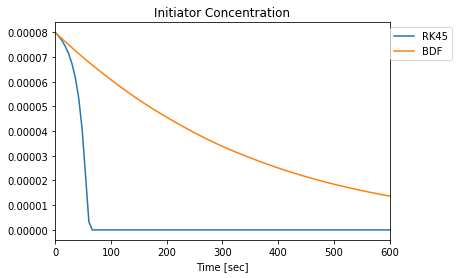

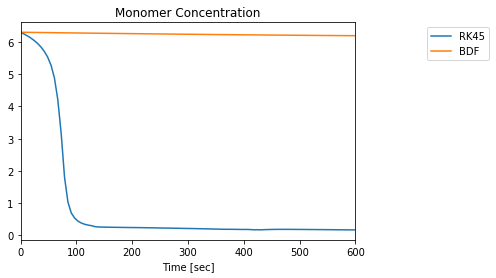

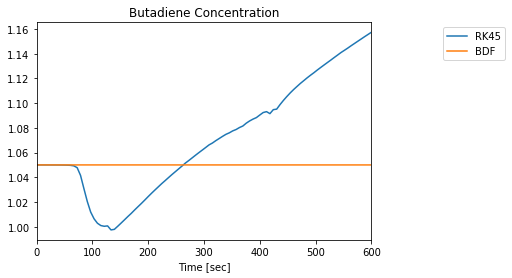

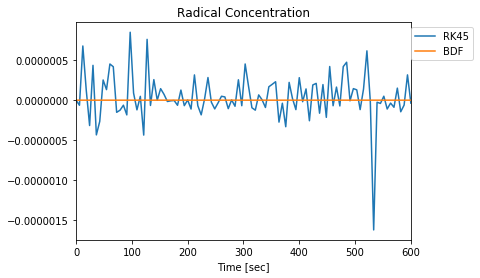

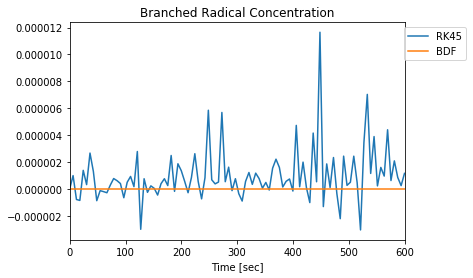

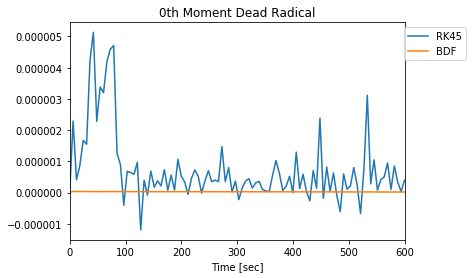

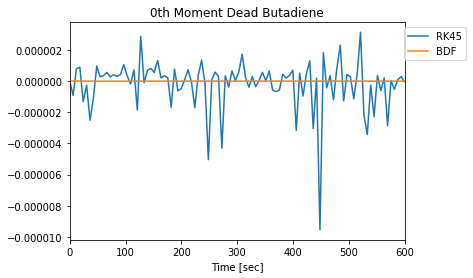

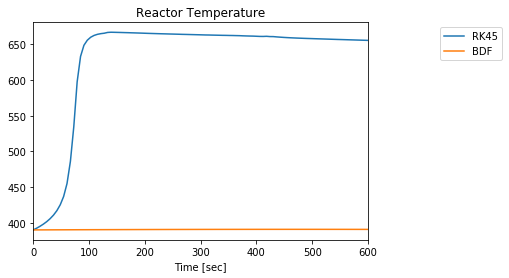

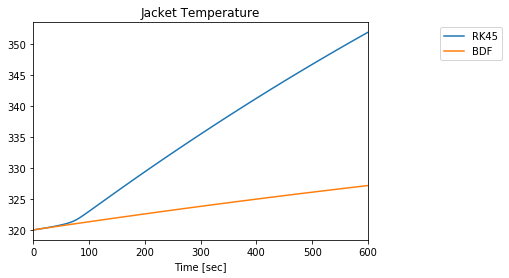

In [20]:
AA = len(y0)
title = ['Initiator Concentration','Monomer Concentration','Butadiene Concentration', 'Radical Concentration','Branched Radical Concentration',
        '0th Moment Dead Radical', '0th Moment Dead Butadiene', 'Reactor Temperature', 'Jacket Temperature']

for i in range(AA):
    plt.plot(A1_sol1.t,A1_sol1.y[i],A1_sol2.t,A1_sol2.y[i])
    plt.title(title[i])
    plt.xlabel('Time [sec]')
    plt.xlim(A1_sol1.t.min(),A1_sol1.t.max())
    plt.legend(['RK45','BDF'],bbox_to_anchor = [1.2,1])
    plt.show()

In [21]:
toctoc = time.perf_counter()
total_computation_time = toctoc - tictic
total_computation_time

13230.063396099998

## References

- Flores-Tlacuahuac, Antonio, et al. “Dynamic Optimization of HIPS Open-Loop Unstable Polymerization Reactors.” Industrial & Engineering Chemistry Research, vol. 44, no. 8, 2005, pp. 2659–2674., doi:10.1021/ie049534p.

- Verazaluce-García, Juan Carlos, et al. “Steady-State Nonlinear Bifurcation Analysis of a High-Impact Polystyrene Continuous Stirred Tank Reactor.” Industrial & Engineering Chemistry Research, vol. 39, no. 6, 2000, pp. 1972–1979., doi:10.1021/ie990560a.
